# Hyperspectral Analysis

In [1]:
import numpy as np
import seaborn as sns

import rasterio
from rasterio.windows import Window

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, AgglomerativeClustering
from sklearn.preprocessing import scale

import matplotlib.colors as clr
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

In [3]:
# do not use it for visualizing the datasets
# use for the analysis part
plt.style.use('seaborn-whitegrid')

## Reading the Datasets

We have two datasets: NIR and VIS.

In [6]:
nir_f = '/Users/vasilii.mosin/Desktop/Research/forest/data/hyperspectral/flight_01_old/Flight_01-08_OrthoNIR25/OrthoNIR25.tif'
vis_f = '/Users/vasilii.mosin/Desktop/Research/forest/data/hyperspectral/flight_01_old/Flight_01-08_OrthoVIS16_/OrthoVIS16.tif'

In [7]:
nir_dataset = rasterio.open(nir_f)
vis_dataset = rasterio.open(vis_f)

In [8]:
print(nir_dataset.shape)
print(vis_dataset.shape)

(7954, 7784)
(7954, 7784)


We read a square patch instead of full mosaic.

In [41]:
SIZE = 512

In [42]:
nir_trees = nir_dataset.read(window=Window(3072, 3072, SIZE, SIZE))
vis_trees = vis_dataset.read(window=Window(3072, 3072, SIZE, SIZE))

In [43]:
print(nir_trees.shape)
print(vis_trees.shape)

(27, 512, 512)
(18, 512, 512)


<IPython.core.display.Javascript object>


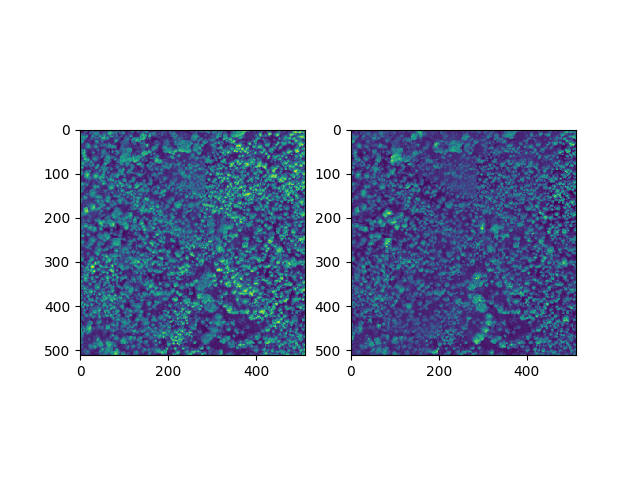

In [44]:
plt.subplot(121)
plt.imshow(nir_trees[0])
plt.subplot(122)
plt.imshow(vis_trees[0])
plt.show()

## Canopies Segmentation

In [45]:
from thresholding_watershed import itcd as itcd_tw

Segmeantation is performed on Band 1 of the NIR dataset.

In [46]:
%%time
polys = itcd_tw(nir_trees[0], smoothing=1, rgb=False, min_distance=6, return_seg=True)

CPU times: user 1.72 s, sys: 16.2 ms, total: 1.73 s
Wall time: 1.74 s


In [16]:
np.save('temp/segmentation_v01', polys)

In [9]:
polys = np.load('temp/segmentation_v01.npy')

In [47]:
n_trees = max(set(polys.flatten()))
print('Trees found:', n_trees)

Trees found: 968


<IPython.core.display.Javascript object>


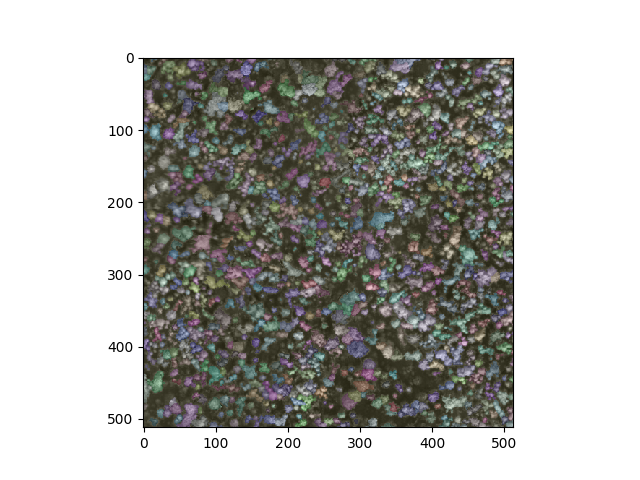

In [48]:
cmap = clr.ListedColormap(np.random.rand(16000,3))

plt.imshow(nir_trees[0], cmap='gray')
plt.imshow(polys, cmap=cmap, alpha=0.2)
plt.show()

In [49]:
%%time
trees_polys = [np.where(polys==i) for i in range(1,n_trees+1)]

CPU times: user 754 ms, sys: 3.34 ms, total: 757 ms
Wall time: 757 ms


In [20]:
np.save('temp/segmentation_by_trees_v01', trees_polys)

In [11]:
trees_polys = np.load('temp/segmentation_by_trees_v01.npy')

In [61]:
np.argsort([len(i[1]) for i in trees_polys])

array([409, 852, 190,  82, 653, 643,   0, 370, 636, 571, 608, 126, 309,
       128, 933, 510,   2, 796, 503, 129, 773, 702, 604, 155,  11, 899,
       460, 505, 422, 697, 215, 479, 628, 570,  42,  86, 262, 769, 685,
        20, 396, 400,  17, 547, 535, 275, 270, 230, 291, 923, 450,  98,
       908, 810,  96, 314, 403, 454, 393, 113, 114, 930, 474, 213, 530,
       808, 226, 287, 912, 886, 822, 356, 621, 392, 867, 332, 374, 635,
       106, 845, 178,  33, 623, 202, 620, 618, 869, 447, 871, 353, 225,
       200, 719, 471,  57, 851, 842, 467, 669, 235, 207, 831, 343, 598,
       539, 737, 797, 819, 907, 941, 358, 405,   5, 531, 709, 619, 257,
       180, 820, 593, 472, 159, 367, 311, 877, 792, 249,  44, 634, 945,
       349,   7, 170, 342, 328, 666, 274,   1, 261, 303, 327, 105, 755,
        76, 116, 419, 657, 931, 389, 550, 757, 889, 568, 856, 120, 646,
       220, 384, 408, 354, 281, 160, 741, 727, 641, 688, 662, 548, 148,
       936, 382, 336, 369, 468, 377, 859, 661, 791, 575, 956, 91

<IPython.core.display.Javascript object>


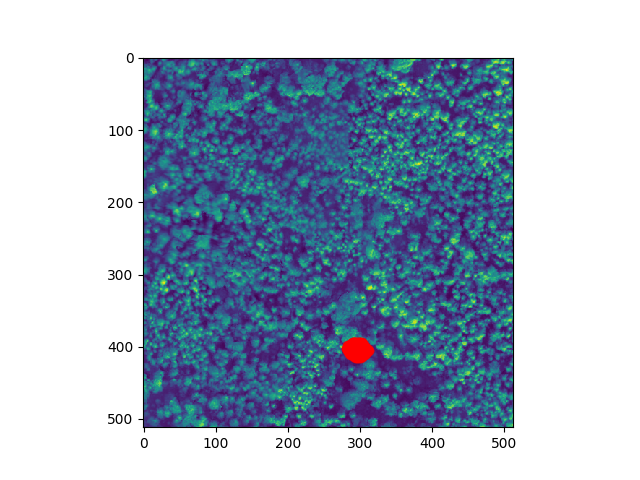

In [66]:
plt.imshow(nir_trees[0])
plt.scatter(trees_polys[780][1], trees_polys[780][0], alpha=0.5, c='r')
plt.show()

In [106]:
tree_780 = np.vstack([vis_trees[1:-1,trees_polys[780][1],trees_polys[780][0]],
                      nir_trees[1:-1,trees_polys[780][1],trees_polys[780][0]]])

<IPython.core.display.Javascript object>


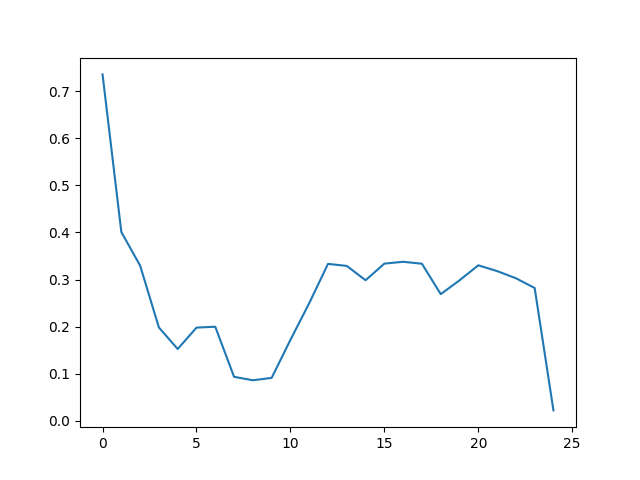

In [110]:
plt.plot(np.mean(nir_trees[1:-1,trees_polys[780][1],trees_polys[780][0]],axis=1)/10000)

## Features Calculation

### NIR features

In [13]:
mean_spectra_nir = [np.mean(nir_trees[:-1,trees_polys[i][1],trees_polys[i][0]],axis=1) for i in range(n_trees)]

In [15]:
median_spectra_nir = [np.median(nir_trees[:-1,trees_polys[i][1],trees_polys[i][0]],axis=1) for i in range(n_trees)]

In [72]:
mean_spectra_bright_nir = []

for i in range(n_trees):
    cur_tree = nir_trees[:-1,trees_polys[i][1],trees_polys[i][0]]
    pixels_average = mean_spectra_nir[i]
    average_matrix = np.repeat(mean_spectra_nir[i],len(trees_polys[i][1])).reshape(26,len(trees_polys[i][1]))
    mask_elements = cur_tree < average_matrix # mask elements that are smaller
    mean_spectra_bright_nir.append(np.ma.mean(np.ma.array(cur_tree, mask=mask_elements),axis=1).data)

In [75]:
median_spectra_bright_nir = []

for i in range(n_trees):
    cur_tree = nir_trees[:-1,trees_polys[i][1],trees_polys[i][0]]
    pixels_average = mean_spectra_nir[i]
    average_matrix = np.repeat(mean_spectra_nir[i],len(trees_polys[i][1])).reshape(26,len(trees_polys[i][1]))
    mask_elements = cur_tree < average_matrix # mask elements that are smaller
    median_spectra_bright_nir.append(np.ma.median(np.ma.array(cur_tree, mask=mask_elements),axis=1).data)

In [78]:
mean_spectra_dark_nir = []

for i in range(n_trees):
    cur_tree = nir_trees[:-1,trees_polys[i][1],trees_polys[i][0]]
    pixels_average = mean_spectra_nir[i]
    average_matrix = np.repeat(mean_spectra_nir[i],len(trees_polys[i][1])).reshape(26,len(trees_polys[i][1]))
    mask_elements = cur_tree > average_matrix # mask elements that are bigger
    mean_spectra_dark_nir.append(np.ma.mean(np.ma.array(cur_tree, mask=mask_elements),axis=1).data)

In [80]:
median_spectra_dark_nir = []

for i in range(n_trees):
    cur_tree = nir_trees[:-1,trees_polys[i][1],trees_polys[i][0]]
    pixels_average = mean_spectra_nir[i]
    average_matrix = np.repeat(mean_spectra_nir[i],len(trees_polys[i][1])).reshape(26,len(trees_polys[i][1]))
    mask_elements = cur_tree > average_matrix # mask elements that are bigger
    median_spectra_dark_nir.append(np.ma.median(np.ma.array(cur_tree, mask=mask_elements),axis=1).data)

In [98]:
mean_spectra_normalized_nir = []

for i in range(n_trees):
    cur_tree = nir_trees[:-1,trees_polys[i][1],trees_polys[i][0]]
    cur_tree_norm = cur_tree/np.sum(cur_tree,axis=0)
    mean_spectra_normalized_nir.append(np.mean(cur_tree_norm, axis=1))

In [120]:
features_nir = np.concatenate((mean_spectra_nir,median_spectra_nir,mean_spectra_bright_nir,median_spectra_bright_nir,
                mean_spectra_dark_nir,median_spectra_dark_nir,mean_spectra_normalized_nir), axis=1)

In [130]:
features_nir_std = scale(features_nir)

### VIS features

In [12]:
mean_spectra_vis = [np.mean(vis_trees[:-1,trees_polys[i][1],trees_polys[i][0]],axis=1) for i in range(n_trees)]

In [156]:
median_spectra_vis = [np.median(vis_trees[:-1,trees_polys[i][1],trees_polys[i][0]],axis=1) for i in range(n_trees)]

In [169]:
mean_spectra_bright_vis = []

for i in range(n_trees):
    cur_tree = vis_trees[:-1,trees_polys[i][1],trees_polys[i][0]]
    pixels_average = mean_spectra_vis[i]
    average_matrix = np.repeat(mean_spectra_vis[i],len(trees_polys[i][1])).reshape(26,len(trees_polys[i][1]))
    mask_elements = cur_tree < average_matrix # mask elements that are smaller
    mean_spectra_bright_vis.append(np.ma.mean(np.ma.array(cur_tree, mask=mask_elements),axis=1).data)

In [170]:
median_spectra_bright_vis = []

for i in range(n_trees):
    cur_tree = vis_trees[:-1,trees_polys[i][1],trees_polys[i][0]]
    pixels_average = mean_spectra_vis[i]
    average_matrix = np.repeat(mean_spectra_vis[i],len(trees_polys[i][1])).reshape(26,len(trees_polys[i][1]))
    mask_elements = cur_tree < average_matrix # mask elements that are smaller
    median_spectra_bright_vis.append(np.ma.median(np.ma.array(cur_tree, mask=mask_elements),axis=1).data)

In [171]:
mean_spectra_dark_vis = []

for i in range(n_trees):
    cur_tree = vis_trees[:-1,trees_polys[i][1],trees_polys[i][0]]
    pixels_average = mean_spectra_vis[i]
    average_matrix = np.repeat(mean_spectra_vis[i],len(trees_polys[i][1])).reshape(26,len(trees_polys[i][1]))
    mask_elements = cur_tree > average_matrix # mask elements that are bigger
    mean_spectra_dark_vis.append(np.ma.mean(np.ma.array(cur_tree, mask=mask_elements),axis=1).data)

In [172]:
median_spectra_dark_vis = []

for i in range(n_trees):
    cur_tree = vis_trees[:-1,trees_polys[i][1],trees_polys[i][0]]
    pixels_average = mean_spectra_vis[i]
    average_matrix = np.repeat(mean_spectra_vis[i],len(trees_polys[i][1])).reshape(26,len(trees_polys[i][1]))
    mask_elements = cur_tree > average_matrix # mask elements that are bigger
    median_spectra_dark_vis.append(np.ma.median(np.ma.array(cur_tree, mask=mask_elements),axis=1).data)

In [173]:
mean_spectra_normalized_vis = []

for i in range(n_trees):
    cur_tree = vis_trees[:-1,trees_polys[i][1],trees_polys[i][0]]
    cur_tree_norm = cur_tree/np.sum(cur_tree,axis=0)
    mean_spectra_normalized_vis.append(np.mean(cur_tree_norm, axis=1))

In [174]:
features_vis = np.concatenate((mean_spectra_vis,median_spectra_vis,mean_spectra_bright_vis,median_spectra_bright_vis,
                mean_spectra_dark_vis,median_spectra_dark_vis,mean_spectra_normalized_vis), axis=1)

In [175]:
features_vis_std = scale(features_vis)

## Unsupervised Analysis

In [13]:
features = mean_spectra_vis

In [14]:
pca = PCA(n_components=2)

In [15]:
features_pca = pca.fit_transform(features)

<IPython.core.display.Javascript object>


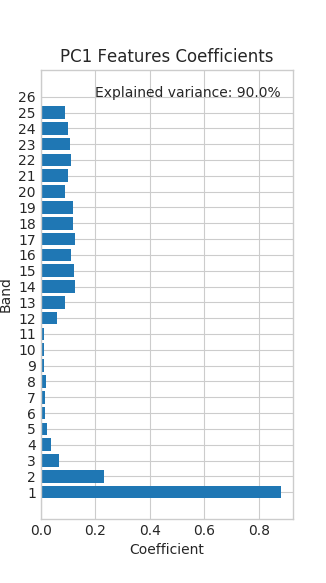

In [40]:
plt.barh(range(1,len(pca.components_[0])+1), abs(pca.components_[0]))
plt.ylabel('Band')
plt.xlabel('Coefficient')
plt.yticks(range(1,len(pca.components_[0])+1))
plt.text(0.2,26,'Explained variance: '+str(round(pca.explained_variance_ratio_[0],2)*100)+'%')
plt.title('PC1 Features Coefficients')
plt.show()

<IPython.core.display.Javascript object>


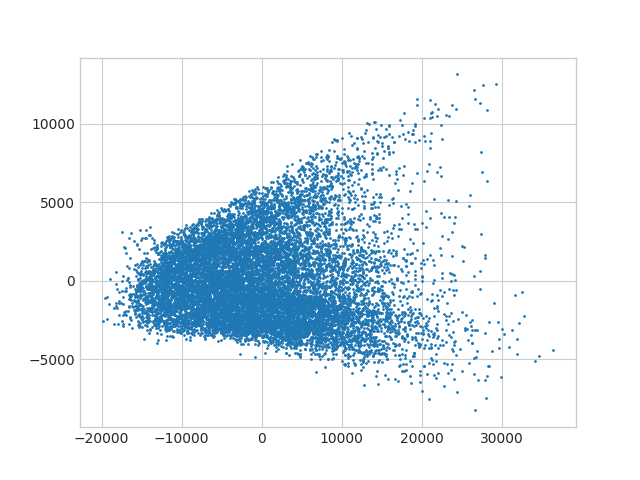

In [19]:
plt.scatter(features_pca[:,0], features_pca[:,1], s=1)
plt.show()

In [16]:
%%time
tsne = TSNE(n_components=2)
features_tsne = tsne.fit_transform(features)

CPU times: user 1min 36s, sys: 4.64 s, total: 1min 41s
Wall time: 1min 41s


In [17]:
clustering = AgglomerativeClustering(n_clusters=4)
clusters = clustering.fit_predict(features_tsne)

<IPython.core.display.Javascript object>


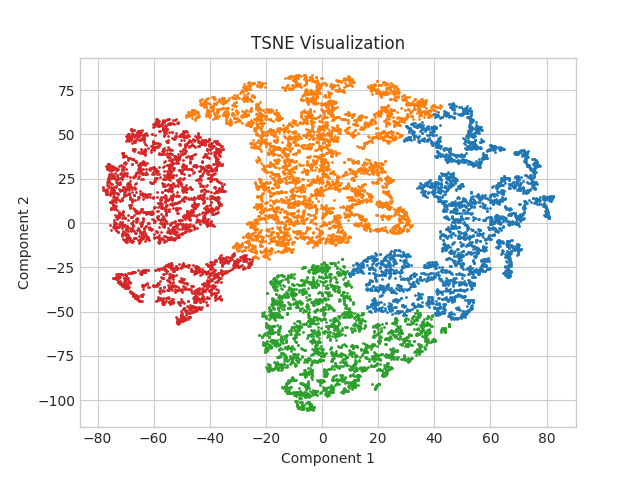

In [61]:
plt.scatter(features_tsne[np.where(clusters==0),0], features_tsne[np.where(clusters==0),1], s=1)
plt.scatter(features_tsne[np.where(clusters==1),0], features_tsne[np.where(clusters==1),1], s=1)
plt.scatter(features_tsne[np.where(clusters==2),0], features_tsne[np.where(clusters==2),1], s=1)
plt.scatter(features_tsne[np.where(clusters==3),0], features_tsne[np.where(clusters==3),1], s=1)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('TSNE Visualization')
plt.show()

<IPython.core.display.Javascript object>


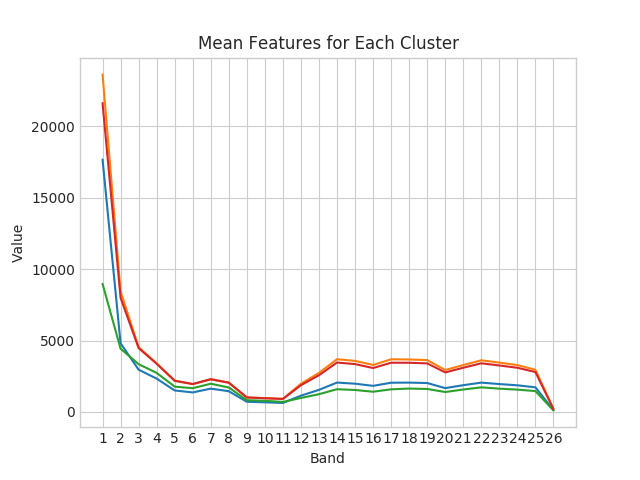

In [62]:
plt.plot(range(1,len(pca.components_[0])+1),np.mean(np.asarray(features)[np.where(clusters==0)], axis=0))
plt.plot(range(1,len(pca.components_[0])+1),np.mean(np.asarray(features)[np.where(clusters==1)], axis=0))
plt.plot(range(1,len(pca.components_[0])+1),np.mean(np.asarray(features)[np.where(clusters==2)], axis=0))
plt.plot(range(1,len(pca.components_[0])+1),np.mean(np.asarray(features)[np.where(clusters==3)], axis=0))
plt.xlabel('Band')
plt.ylabel('Value')
plt.xticks(range(1,len(pca.components_[0])+1))
plt.title('Mean Features for Each Cluster')
plt.show()

<IPython.core.display.Javascript object>


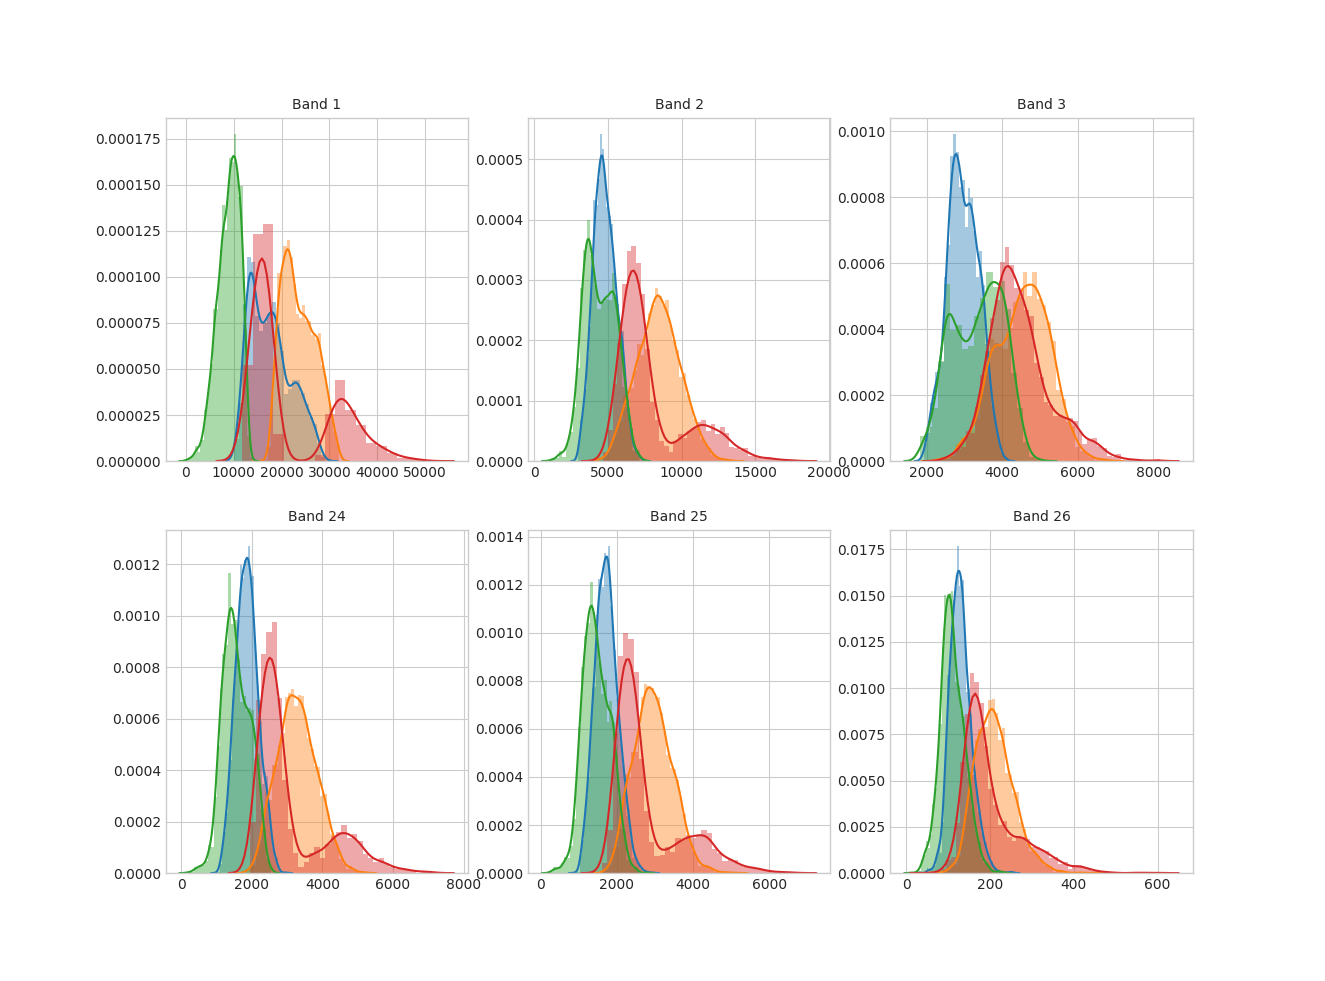

/Users/vasilii.mosin/.virtualenvs/forestry/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [63]:
plt.subplot(2,3,1)
sns.distplot(np.asarray(features)[np.where(clusters==0)][:,0])
sns.distplot(np.asarray(features)[np.where(clusters==1)][:,0])
sns.distplot(np.asarray(features)[np.where(clusters==2)][:,0])
sns.distplot(np.asarray(features)[np.where(clusters==3)][:,0])
plt.title('Band 1', size=10)
plt.subplot(2,3,2)
sns.distplot(np.asarray(features)[np.where(clusters==0)][:,1])
sns.distplot(np.asarray(features)[np.where(clusters==1)][:,1])
sns.distplot(np.asarray(features)[np.where(clusters==2)][:,1])
sns.distplot(np.asarray(features)[np.where(clusters==3)][:,1])
plt.title('Band 2', size=10)
plt.subplot(2,3,3)
sns.distplot(np.asarray(features)[np.where(clusters==0)][:,2])
sns.distplot(np.asarray(features)[np.where(clusters==1)][:,2])
sns.distplot(np.asarray(features)[np.where(clusters==2)][:,2])
sns.distplot(np.asarray(features)[np.where(clusters==3)][:,2])
plt.title('Band 3', size=10)
plt.subplot(2,3,4)
sns.distplot(np.asarray(features)[np.where(clusters==0)][:,23])
sns.distplot(np.asarray(features)[np.where(clusters==1)][:,23])
sns.distplot(np.asarray(features)[np.where(clusters==2)][:,23])
sns.distplot(np.asarray(features)[np.where(clusters==3)][:,23])
plt.title('Band 24', size=10)
plt.subplot(2,3,5)
sns.distplot(np.asarray(features)[np.where(clusters==0)][:,24])
sns.distplot(np.asarray(features)[np.where(clusters==1)][:,24])
sns.distplot(np.asarray(features)[np.where(clusters==2)][:,24])
sns.distplot(np.asarray(features)[np.where(clusters==3)][:,24])
plt.title('Band 25', size=10)
plt.subplot(2,3,6)
sns.distplot(np.asarray(features)[np.where(clusters==0)][:,25])
sns.distplot(np.asarray(features)[np.where(clusters==1)][:,25])
sns.distplot(np.asarray(features)[np.where(clusters==2)][:,25])
sns.distplot(np.asarray(features)[np.where(clusters==3)][:,25])
plt.title('Band 26', size=10)
plt.show()

## Clusters Visualization

In [18]:
clustered_polys = np.copy(polys)

In [19]:
class_1 = np.isin(clustered_polys, np.where(clusters==0)[0]+1)
class_2 = np.isin(clustered_polys, np.where(clusters==1)[0]+1)
class_3 = np.isin(clustered_polys, np.where(clusters==2)[0]+1)
class_4 = np.isin(clustered_polys, np.where(clusters==3)[0]+1)

In [20]:
clustered_polys[class_1] = 1
clustered_polys[class_2] = 2
clustered_polys[class_3] = 3
clustered_polys[class_4] = 4

<IPython.core.display.Javascript object>


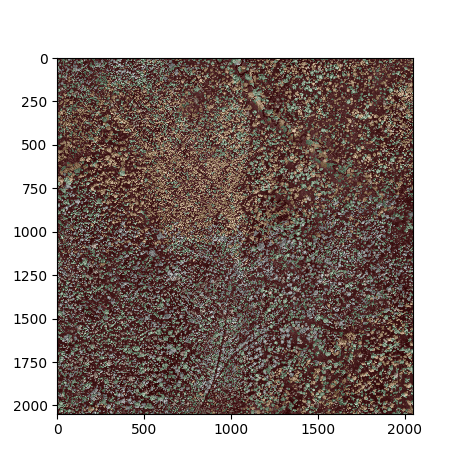

In [24]:
plt.imshow(nir_trees[0], cmap='gray')
plt.imshow(clustered_polys, cmap='Set1', alpha=0.2)
plt.show()